In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
    
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
    
        var cells = IPython.notebook.get_cells();
    
    
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import gridspec
from matplotlib import colors

import os
import re
import numpy as np
import pandas as pd
import cooler

import itertools

In [4]:
import seaborn as sns

In [5]:
import bioframe
from bioframe.io import resources
from bioframe import io

In [6]:
# cooltools used dekkerlab-fork, develop-branch, commit-af508bba9c6577b8271b716ba27c330bead15981
from cooler.tools import split, partition
from functools import partial
from cooltools import expected

In [7]:
from helper_module import fillcolor_compartment_style, to_uscs

In [8]:
from cooltools import numutils
from cooltools.eigdecomp import cooler_cis_eig

In [9]:
cooler_names = [
    'all-allele-spe-2percent-highcis.galGal5.mapq_30.1000.mcool',
    'all-allele-spe-1percent-highcis.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-1-3-16-2p-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-1-3-16-R2-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-1-3-17-2p-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-1-3-17-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-WT1-R1-T1__galGal5.galGal5.mapq_30.1000.mcool',
    'MNP-DT40-WT2-R1-T1__galGal5.galGal5.mapq_30.1000.mcool']

### generate some nicer sample names from coolers ...

In [10]:
# multiqc learnings here, btw!...
renamings = {"all-allele-spe":"pool",
            ".galGal5.mapq_30.1000.mcool":"",
            "MNP-DT40-":"",
            "-T1__galGal5":"",
            "-R1":"",
            "1-3-":"clone-"}

sample_names = []
for c in cooler_names:
    for rf,rt in renamings.items():
        c = re.sub(rf,rt,c)
    sample_names.append(c)

# sample_names

# form a df of samples here:
samples = pd.DataFrame({"sample":sample_names,"mcool":cooler_names})

samples

,sample,mcool
0,pool-2percent-highcis,all-allele-spe-2percent-highcis.galGal5.mapq_3...
1,pool-1percent-highcis,all-allele-spe-1percent-highcis.galGal5.mapq_3...
2,clone-16-2p,MNP-DT40-1-3-16-2p-R1-T1__galGal5.galGal5.mapq...
3,clone-16-R2,MNP-DT40-1-3-16-R2-T1__galGal5.galGal5.mapq_30...
4,clone-17-2p,MNP-DT40-1-3-17-2p-R1-T1__galGal5.galGal5.mapq...
5,clone-17,MNP-DT40-1-3-17-R1-T1__galGal5.galGal5.mapq_30...
6,WT1,MNP-DT40-WT1-R1-T1__galGal5.galGal5.mapq_30.10...
7,WT2,MNP-DT40-WT2-R1-T1__galGal5.galGal5.mapq_30.10...


In [11]:
# READ SOME COOLERS ...
binsize = 100_000
res_human = f"{int(binsize/1000)}kb"

# oldref-20200617
cool_path = "/home/venevs/DOTS_TESTING/alv-chicken/oldref-20200617"
get_cpath = lambda c: os.path.join(cool_path,c+f"::/resolutions/{binsize}")

samples["cool"] = [cooler.Cooler(get_cpath(c)) for c in samples["mcool"]]
samples["sum"] = [s.info["sum"] for s in samples["cool"]]

In [12]:
clr, = samples["cool"][samples["sample"] == "pool-2percent-highcis"].values

chrom = "chr1"
parm = (chrom,0,74626886)
qarm = (chrom,75126886,196202544)
centro = (chrom,74626886,75126886)
balance = True

# bad_bins = None
ignore_diags = 2
theregion=parm
theregion_name="parm"

bad_bin_regions = [(chrom,9_000_000,9_500_000),(chrom,32_270_000,32_770_000)]
bad_bins = np.concatenate([np.arange(*clr.extent(_bb)) for _bb in bad_bin_regions])


weight_name = "weight"
weight1 = weight_name + "1"
weight2 = weight_name + "2"
transforms = {"balanced": lambda p: p["count"] * p[weight1] * p[weight2]}

### read replication timing to use as a phasing track (only `chr1` is available)

In [13]:
val_rt = io.read_table(
    "/home/venevs/DOTS_TESTING/alv-chicken/timing_wt.bed",
    schema="bedGraph",
    skiprows=1
)

bins = clr.bins().fetch(chrom).copy()

# overlap RT signal with our bins ...
binned_rt = bioframe.ops.overlap(bins, val_rt, suffixes=['', '_rt']) \
    .drop(labels=["chrom_rt","start_rt","end_rt","weight"],axis="columns") \
    .fillna(np.nan) # addressing pd.NA issue with this

# finally :
binned_rt = binned_rt \
    .groupby(["chrom","start","end"],observed=True,sort=False) \
    .mean() \
    .reset_index()

### compute compartments per arm masking bad bins ...

(0.0, 1963.0)

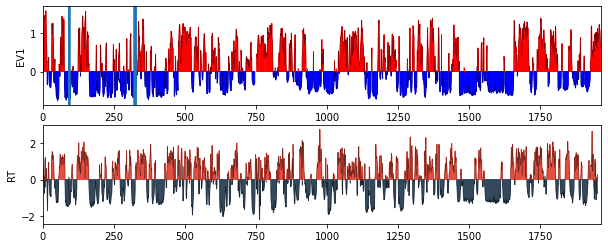

In [14]:
eigvals1, eigvec_table1 = cooler_cis_eig(
    clr=clr,
    bins=binned_rt,
    regions= [parm, qarm],
    n_eigs=2,
    bad_bins = bad_bins,
    phasing_track_col="value_rt",
    clip_percentile=99.9,
    sort_metric=None,
)

# plot it, just in case:
f = plt.figure(figsize=(10,4))
ax = f.add_subplot(2,1,1)
axrt = f.add_subplot(2,1,2)
fillcolor_compartment_style(eigvec_table1["E1"], ax)
for bb in bad_bins:
    ax.axvline(bb)

fillcolor_compartment_style(binned_rt["value_rt"], axrt, color_less="#34495e", color_more="#e74c3c")

ax.set_ylabel("EV1")
axrt.set_ylabel("RT")
ax.set_xlim(*clr.extent(chrom))
axrt.set_xlim(*clr.extent(chrom))

### generating nice piece of Hi-C heatmap for technical supplement

your regions spans from 0Mb to 74Mb
colorbar ticks are going to be ...
[6e-05, 0.0001, 0.0095]


/home/venevs/miniconda3/envs/newexp/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


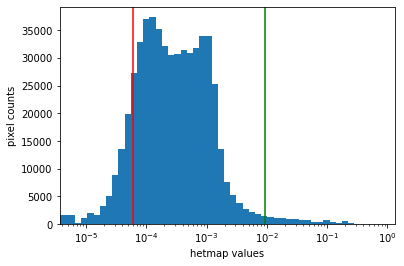

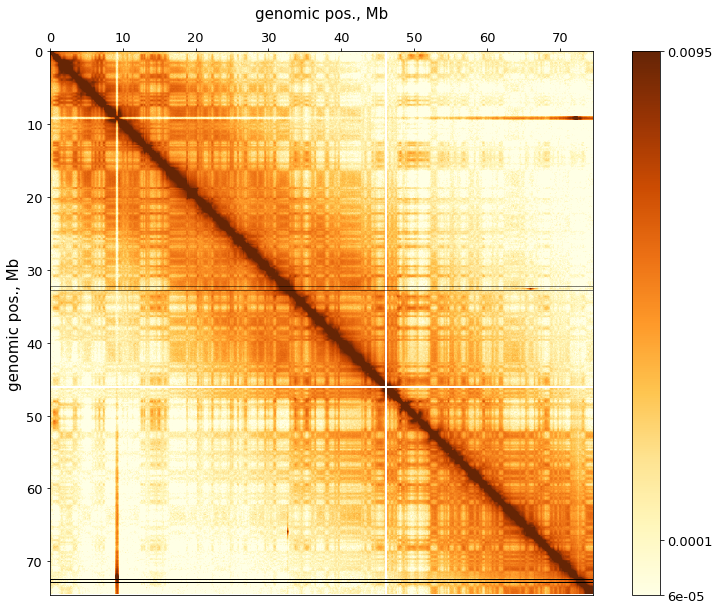

In [15]:
# getting a symmetric region:
ucsc_region = "chr1:10000000-120000000"
ucsc_region = to_uscs(parm)
parm_len = parm[2] - parm[1]
# ucsc_region = chrom

rsize, = np.diff(clr.extent(ucsc_region))

matrix = clr.matrix(balance=True).fetch(ucsc_region)

# what's the dynamic range of the matrix,
# i.e. minimal and maxmum values ...
mmin = np.nanmin(matrix[matrix>0]) # minimal non-zero value
mmax = np.nanmax(matrix)
# we use nanmin/max to ignore NaNs in the matrix


# if you want to dive deep into colorscale normalization, understand
# how many pixels on your heatmap are "dark" and , how many are "bright"
# i.e. histogram of the matrix values in log space
# x-axis is basically your colorbar ...
logbins = np.r_[0,np.geomspace(mmin,mmax)] # from 0 to min-non-zero is the first "bin"
plt.hist(matrix.flatten(),bins=logbins,log=False)
plt.xscale("log")
plt.xlabel("hetmap values")
plt.ylabel("pixel counts")

# peek your vmin/vmax here - matrix values that correspond to the lightest/darkes
# colormap colors:
vmin = 0.00006
vmax = 0.0095

# that's where they are on the histogram of colors:
plt.axvline(vmin,color="red")
plt.axvline(vmax,color="green")

# USE KNOWLEDGE OBTAINED FROM THE HISTOGRAM OF VALUES TO CREATE
# AN EDUCATED COLOR NORMALIZATION FOR THE FUTURE HEATMAP ...
# how to normalize colors/values http://members.cbio.mines-paristech.fr/~nvaroquaux/tmp/matplotlib/users/colormapnorms.html
# try to tweak vmin/vmax to achieve better contrast etc:
color_norm = colors.SymLogNorm(linthresh=mmin,vmin=vmin,vmax=vmax,base=10)


reg_bin_start, reg_bin_end = clr.extent(ucsc_region)
reg_start, = clr.bins()["start"][reg_bin_start].values
reg_end, = clr.bins()["start"][reg_bin_end-1].values
print(f"your regions spans from {int(reg_start/1_000_000)}Mb to {int(reg_end/1_000_000)}Mb")

# prepare "origin" "extent" for the future heatmap:
# https://matplotlib.org/3.1.0/tutorials/intermediate/imshow_extent.html
origin="upper"
heatmap_extent = [reg_start,reg_end,reg_end,reg_start]

# also create nice ticks for the colorbar !
# calculate the tick between vmin and vmax - geometric mean:
mid_base_bot = np.floor(np.log10(np.sqrt(vmin*vmax)))
mid_base_top = np.ceil(np.log10(np.sqrt(vmin*vmax)))
if vmin < 10**mid_base_bot < vmax:
    vmid = 10**mid_base_bot
    cb_ticks = [vmin, vmid, vmax]
elif vmin < 10**mid_base_top < vmax:
    vmid = 10**mid_base_top
    cb_ticks = [vmin, vmid, vmax]
else:
    cb_ticks = [vmin,vmax]

print("colorbar ticks are going to be ...")
print(cb_ticks)

# SUBSTITUTE SOME VALUES MANUALLY IF THE RESULT IS UGLY ...

# figure parameters:
width = 14
height = 10
heatmap_cmap = "YlOrBr" # get more by googling: "colormap matplotlib"

# create empty figure, aka canvas ...
fig = plt.figure(figsize=(width, height))
# on that figure add new axes:
ax = fig.add_subplot()

img = ax.imshow(matrix, norm = color_norm ,cmap=heatmap_cmap, extent = heatmap_extent,origin=origin)
cbar = fig.colorbar(img)
cbar.set_ticks(cb_ticks)
cbar.set_ticklabels(cb_ticks)
cbar.ax.tick_params(labelsize=13) 

# # deal with ticks and their labels ...
ax.tick_params(bottom=False,labelbottom=False,left=True,labelleft=True,top=True,labeltop=True)

# turn float tciks into nice , megabase based ticks
ax.set_xticklabels([f"{int(x/1000000)}" for x in ax.get_xticks()],fontsize=13)
ax.set_yticklabels([f"{int(y/1000000)}" for y in ax.get_yticks()],fontsize=13)

# add x/y labels and tweak their position a bit ...
ax.set_xlabel("genomic pos., Mb",labelpad=25,fontsize=15)
ax.set_ylabel("genomic pos., Mb",fontsize=15)
ax.xaxis.label_position = "top"

locus_bin=72_500_000
ins_row = clr.offset((chrom,locus_bin,locus_bin+binsize))

rect1 = plt.Rectangle((0, locus_bin), parm_len,400_000, fill=False, linewidth=1)
ax.add_patch(rect1)

locus_bin=32_270_000

rect1 = plt.Rectangle((0, locus_bin), parm_len,500_000, fill=False, linewidth=0.51)
ax.add_patch(rect1)


### showing available "unfiltered" data for clone 16,17 , combined 
 for technical supplement ...

/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:28: RuntimeWarning: invalid value encountered in less_equal
  ax.fill_between(x,y0,y,where=(y<=level),color = color_less)
/home/venevs/DOTS_TESTING/alv-chicken/allelic-rt-supplement/helper_module.py:29: RuntimeWarning: invalid value encountered in greater
  ax.fill_between(x,y0,y,where=(y>level),color = color_more)


Text(0.5, 0, 'genomic pos, Mb')

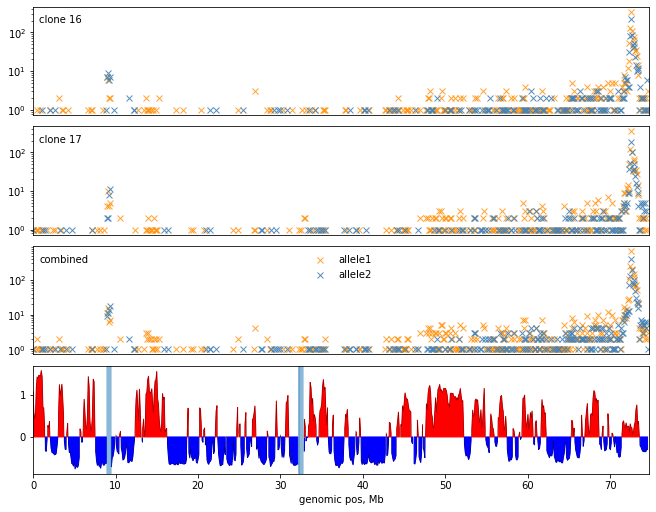

In [16]:
from matplotlib import ticker


# visualize compartments:
f = plt.figure(figsize=(9,7),constrained_layout=True)
sp1 = f.add_gridspec(ncols=1, nrows=4)#, height_ratios=[2,1], figure=f)



ax1 = f.add_subplot(sp1[0])
ax2 = f.add_subplot(sp1[1])
ax3 = f.add_subplot(sp1[2])

ax4 = f.add_subplot(sp1[3])


# clr = samples["cool"][0]
# chr1_parm = "chr1:0-74626886"
# chr1_qarm = "chr1:74626887-196202544"

chr1_parm = to_uscs(parm)
balanced = False
p_range_zoom = clr.extent(chr1_parm)
log=True



samplez = "clone-16-2p"
clr1, = samples["cool"][samples["sample"] == samplez].values
samplez = "clone-17-2p"
clr2, = samples["cool"][samples["sample"] == samplez].values
samplez = "pool-2percent-highcis"
clr3, = samples["cool"][samples["sample"] == samplez].values


# extract balacing weights for
# alleles 1 and 2 - they are meaningless I guess
# they only reflect - the total # of interactions
# between allele1/2 and chr1
for clr,ax,samp in zip([clr1,clr2,clr3],[ax1,ax2,ax3],["clone 16","clone 17","combined"]):
    if balanced:
        w1, = clr.bins().fetch("allele1")["weight"]
        w2, = clr.bins().fetch("allele2")["weight"]
        # print(w1,w2)
    # p-arm data:
    # obs:
    d1p, = clr.matrix(balance=balanced).fetch("allele1",chr1_parm)
    d2p, = clr.matrix(balance=balanced).fetch("allele2",chr1_parm)
    if balanced:
        d1p /= w1
        d2p /= w2
    xp = range(*p_range_zoom)
    ax.plot(xp, d1p[slice(*p_range_zoom)], color="darkorange",marker='x',linewidth=0,label="allele1", alpha=0.8)
    ax.plot(xp, d2p[slice(*p_range_zoom)], color='steelblue',marker='x',linewidth=0,label="allele2", alpha=0.9)
    ax.set_xlim(*p_range_zoom)
    if log:
        ax.set_yscale("log")
    ax.tick_params(bottom=False,labelbottom=False)
    ax.text(0.01,0.85,samp,transform=ax.transAxes)


ax.legend(loc="upper center",frameon=False)

# bottom row, compartments:
cmpp = eigvec_table1["E1"].values[slice(*p_range_zoom)]
fillcolor_compartment_style(cmpp, ax4)
ax4.set_xlim(*p_range_zoom)
for bb in bad_bins:
    ax4.axvline(bb,alpha=0.4)


ax4.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*binsize/1_000_000)}"))
ax4.set_xlabel("genomic pos, Mb")
    